## Setup

In [1]:
# # check GPU
!nvidia-smi

Sat Jan 14 23:21:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!rm -rf mode_connectivity
# # pulls repo to colab
!git lfs clone https://github.com/char-tan/mode_connectivity.git

# # checkout specific branch if needed
!cd mode_connectivity

          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
Cloning into 'mode_connectivity'...
remote: Enumerating objects: 1023, done.
remote: Counting objects: 100% (215/215), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 1023 (delta 105), reused 137 (delta 90), pack-reused 808
Receiving objects: 100% (1023/1023), 38.35 MiB | 30.00 MiB/s, done.
Resolving deltas: 100% (601/601), done.
Git LFS: (30 of 30 files) 4.36 GB / 4.36 GB


In [3]:
# allows you to change the .py files and have the imports updated
%load_ext autoreload
%autoreload 2

In [4]:
import sys, os
SCRIPT_DIR = os.path.dirname(os.path.abspath('.'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

sys.path.append("mode_connectivity")

In [9]:
import torch
from torchvision import transforms, datasets
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from mode_connectivity.utils import weight_matching, data, training_utils, plot, utils
from mode_connectivity.training_config import *
from mode_connectivity.lmc import *
from mode_connectivity.training import *

from mode_connectivity.models.mlp import MLP
from mode_connectivity.models.resnet import ResNet
from mode_connectivity.models.vgg import VGG

## Geodesic opt

In [72]:
from utils.utils import get_device
from super import SuperModel
from mode_connectivity.geodesic_opt import optimise_for_geodesic, compare_lmc_to_geodesic, plot_lmc_geodesic_comparison_obj
from mode_connectivity.utils.metrics import JSD_loss, squared_euclid_dist, index_distance

device, _ = get_device()
path = "mode_connectivity/model_files/"
train_kwargs = {"batch_size": 128, 'num_workers': 0, 'pin_memory': False}
test_kwargs = {"batch_size": 128, 'num_workers': 0, 'pin_memory': False}
train_loader, test_loader = data.get_data_loaders(
    dataset="mnist", train_kwargs=train_kwargs, test_kwargs=test_kwargs, eval_only=True,
)

def load_weights(name, permuted):
    path1 = path + name + "_a.pt"
    path2_end = "_b_permuted.pt" if permuted else "_b.pt"
    path2 = path + name + path2_end
    return torch.load(path1, map_location=device), torch.load(path2, map_location=device)

def get_dataloaders(dataset): # returns a (test, train) pair
    if dataset == "mnist":
        return data.get_data_loaders(
            dataset="mnist", train_kwargs=train_kwargs, test_kwargs=test_kwargs, eval_only=True
        )
    elif dataset == "cifar10":
        return data.get_data_loaders(
            dataset="mnist", train_kwargs=train_kwargs, test_kwargs=test_kwargs, eval_only=True
        )

In [37]:
# SAMPLE USAGE:
weights_a, weights_b = load_weights("resnet_wm1", True)
mnist_train, mnist_test = get_dataloaders("mnist")

In [41]:
mlp_config = (MLP, "mlp_mnist_model", "", "mnist")
resnet_config = lambda n : (ResNet, "resnet_wm", str(n), "cifar10")
vgg_config = lambda n : (VGG, "vgg_wm", str(n), "cifar10")
# see model_files folder for which numbers are valid

def make_super(config, n, permuted):
    # if permuted=True, uses the permuted version of the weights
    # (it is assumed both permuted and non-permuted exist, this is not a given)
    model_factory, name, name_n, dataset_name = config
    weights_a, weights_b = load_weights(name + name_n, permuted)
    trainloader, testloader = get_dataloaders(dataset_name)
    return SuperModel(config[0], n, weights_a, weights_b).to(device), trainloader, testloader, model_factory

# EXAMPLE USE:
super_mlp = make_super(mlp_config, 20, True)
super_resnet = make_super(resnet_config(1), 20, False)


## HELPER PLOTTING CODE:
def rolling_mean(x, window):
    return np.convolve(x, np.ones(window), 'valid') / window

def opt_plot(path_lengths, sq_euc_dists, rolling_mean_length=50):
    fig, ax = plt.subplots()

    rolling_mean_length = rolling_mean(path_lengths, rolling_mean_length)

    loss_type = 'JSD loss'

    ax.plot(rolling_mean_length, color = 'red')
    ax.set_xlabel('GD iteration', fontsize = 14)
    ax.set_ylabel('path action via ' + loss_type, color = 'red', fontsize = 14)

    ax2=ax.twinx()
    ax2.plot(sq_euc_dists, color = 'blue')
    ax2.set_ylabel('path action via (squared) euclid dist', color = 'blue', fontsize = 14)
    fig.show()

### Use these cells to mess with experiments:

In [42]:
# See previous code cell for definition of mlp_config, resnet_config, vgg_config.
# Use these in conjunction with make_super to easily get the model and train_loader, to use in the next cell.
super_model, train_loader, test_loader, model_factory = make_super(mlp_config, 20, False)

Optimising geodesic ...
Epoch 0 of 1


100%|██████████| 469/469 [00:13<00:00, 35.58it/s]


epoch 0 | path length 0.07163993989639698 | sq euc dist 87.4646773836506


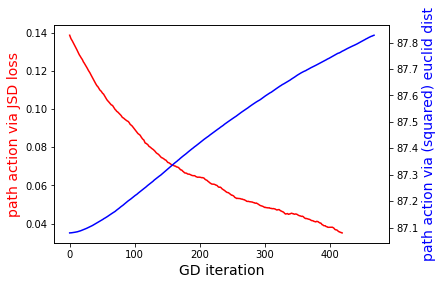

In [43]:
# Run to train; rerun to continue training.
path_lengths, sq_euc_dists  = optimise_for_geodesic(
         super_model,
         train_loader,
         lr = 1e-1,
         verbose=1,
         num_epochs=1)

opt_plot(path_lengths, sq_euc_dists)

Calculating LMC train accuracies ...
Calculating path length and acc over SuperModel:


100%|██████████| 79/79 [00:00<00:00, 85.84it/s]


Calculating geodesic train accuracies ...
Calculating path length and acc over SuperModel:


100%|██████████| 79/79 [00:00<00:00, 86.65it/s]


(<Figure size 864x360 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f508d7277c0>,
       dtype=object))

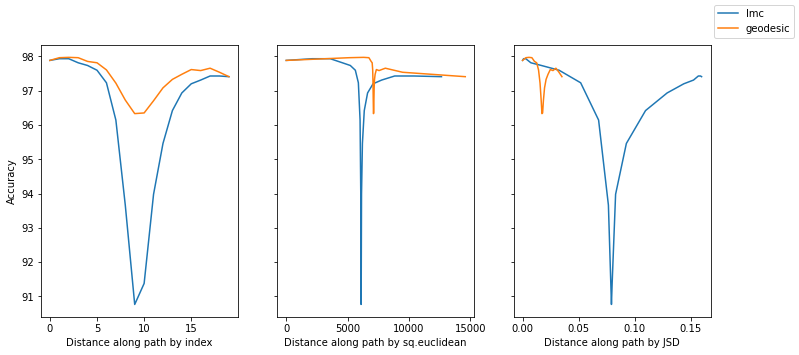

In [100]:
# plot the loss barrier of the trained super_model, compared to LMC:
comparison = compare_lmc_to_geodesic(
    super_model,
    model_factory,
    test_loader,
    distance_metric={
        "index": index_distance,
        "sq.euclidean": squared_euclid_dist,
        "JSD": JSD_loss
    },
    verbose = 1,
)
plot_lmc_geodesic_comparison_obj(comparison, figsize=(12, 5))

Calculating LMC train accuracies ...
Calculating path length and acc over SuperModel:


100%|██████████| 79/79 [00:00<00:00, 85.71it/s]


Calculating geodesic train accuracies ...
Calculating path length and acc over SuperModel:


100%|██████████| 79/79 [00:00<00:00, 87.07it/s]


Calculating LMC train accuracies ...
Calculating path length and acc over SuperModel:


100%|██████████| 469/469 [00:05<00:00, 88.88it/s]


Calculating geodesic train accuracies ...
Calculating path length and acc over SuperModel:


100%|██████████| 469/469 [00:05<00:00, 90.58it/s]


(<Figure size 864x360 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f508d4b6d90>,
       dtype=object))

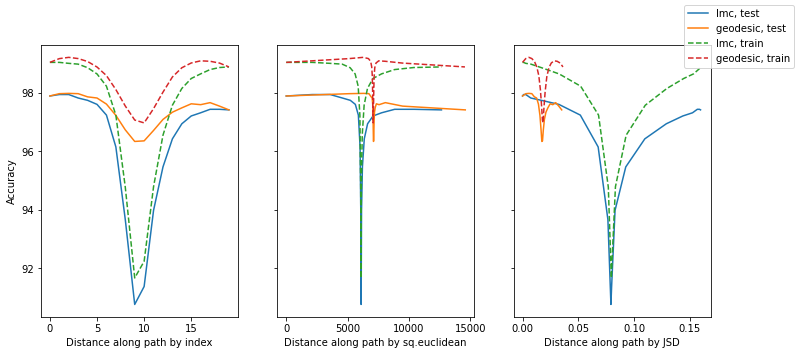

In [103]:
# plot the loss barrier of the trained super_model, compared to LMC:
comparison = compare_lmc_to_geodesic(
    super_model,
    model_factory,
    (test_loader, train_loader),
    distance_metric={
        "index": index_distance,
        "sq.euclidean": squared_euclid_dist,
        "JSD": JSD_loss
    },
    verbose = 1,
)
plot_lmc_geodesic_comparison_obj(comparison, figsize=(12, 5))

In [30]:
# TODO: plot contour plot / anything else to be plotted about the trained model: